# Validating solver code

This notebook is part of the code for my (Elvis Sikora) bachelor thesis.

We will compute the drag coefficient and Strouhal number of 2D low-Reynolds flow around a circular cylinder.
The goal here is to try to validate the OpenFOAM code I am using to solve cases
that are fed to a neural network.

In [1]:
# should we skip solving cases (which is very time-consuming)?
# useful for multiple runs of this file
SKIP_SOLVING = True

### Importing needed external libraries

First of all, activate the `autoreload` magic so that if I make any changes to the
code in external files, they are automatically reloaded here.

In [2]:
%load_ext autoreload
%autoreload 2

Importing standard libraries:

In [3]:
from pathlib import Path

Importing external libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal

Now importing my own code 

In [5]:
import cloud_array as ca
from cloud_array import load_forces, CloudArray
from main import solve_single_case
import validation as val

The last needed bit:

In [6]:
import sys
sys.path.append('..') 
from train import Dataset

### Setting up the directories

Let's check that we are in the correct directory. We should be in the `solver` subdir under the repo's base.

In [7]:
assert Path('.').resolve().name == 'solver'
assert Path('./validation.py').exists()

If there are previously solved cases in the `./data` dir, we should nuke them:

In [8]:
ls ./data

1/  10/  11/  12/  13/  2/  3/  4/  5/  6/  7/  8/  9/


In [9]:
if not SKIP_SOLVING:
    Path('./data').rename('old_data')

### Solving cases

First, we define some (carefully tweaked by hand) parameters:

In [10]:
diameter = 1. # cylinder diameter
nu = .01 # kinematic viscosity
edge_lc = 2. # a mesh discretization parameter
n_steps = 128 # circle is discretized as a polygon of n_steps vertices

def single_case(reynolds):
    return val.single_validation_case(reynolds=reynolds,
                                      diameter=diameter,
                                      nu=nu,
                                      edge_lc=edge_lc,
                                      n_steps=n_steps)

Now, the Reynolds numbers and the cases we are using for our validation:

In [11]:
reynolds_nums = [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

val_cases = [single_case(rey) for rey in reynolds_nums]
num_cases = len(val_cases)

Now, we actually solve those cases (WARNING: it takes something like half an hour in my machine)

In [12]:
if not SKIP_SOLVING:
    solve_cases(val_cases,
                openfoam_dir='./OpenFOAM',
                cloud_array=ca.CloudArray(),
                target_base_dir='./data',
                verbose=True,
                n_cases=num_cases)

The OpenFOAM case and accompanying Python code was primarily based on [Thuerey et al.'s code](https://github.com/thunil/Deep-Flow-Prediction).
After getting good values for $C_D$ but not for the Strouhal number, 
I also adapted code from [Joel Guerrero's tutorial](https://wiki.openfoam.com/Vortex_shedding_by_Joel_Guerrero_2D).

Many thanks to those authors!

### Loading the forces

First, we compare the drag coefficient found by the simulations with reference values 
taken from [Anderson et al., 2016. Fundamentals of Aerodynamics](https://books.google.com.br/books?id=_7VLjwEACAAJ).

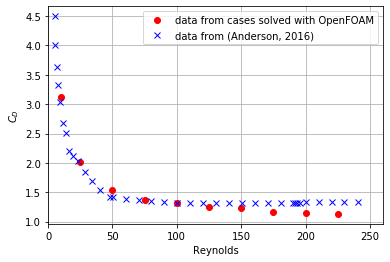

In [13]:
val.compare_forces('./data', lower_re=5, higher_re=250, xlim=(0, 260))

### Computing the Fast Fourier Transform

Now we go step-by-step in finding the Strouhal number
of a single case just to illustrate how it's done.
After that we do this automatically for all cases at once.

Based on code on the file [strouhal.py](https://github.com/Comflics/Exploring-OpenFOAM/blob/master/laminarVortexShedding/strouhal.py)
from comflics's tutorial:
+ [github](https://github.com/Comflics/Exploring-OpenFOAM)
+ [youtube](https://www.youtube.com/watch?v=ylZQXiEdYYo)
+ [blog](http://comflics.blogspot.com/2014/08/openfoam-tutorial-4-laminar-vortex-shedding.html)
+ [pdf](https://nbviewer.jupyter.org/github/Comflics/Exploring-OpenFOAM/blob/master/Exploring-OpenFOAM.pdf)


First, we load a solved case:

In [14]:
dataset = Dataset('./data')
case = dataset.get_sample(10)

We check its Reynolds:

In [15]:
case.reynolds

300

And load the lift coefficient time series:

In [16]:
lift_coeff_series = case.force_series('C_L')

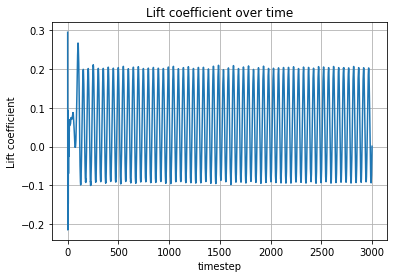

In [17]:
plt.plot(lift_coeff_series)
plt.grid('on')
plt.ylabel('Lift coefficient')
plt.xlabel('timestep')
plt.title('Lift coefficient over time')
plt.show()

We find the timestep in the series:

In [18]:
time_series = case.force_series('times')
dt = time_series[1] - time_series[0]

Now we define a very sensitive parameter, the window size used to compute the FFT:

In [19]:
window_size = 100

Now, computing the FFT:

In [20]:
freq, cl_amp = signal.welch(lift_coeff_series, 1./dt, nperseg=window_size)

Plotting the transformed signal:

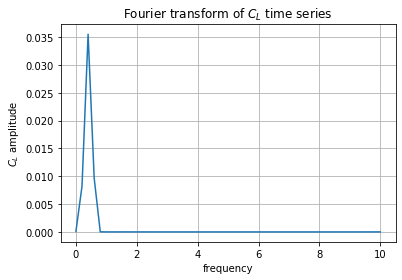

In [21]:
plt.plot(freq, cl_amp)         
plt.grid('on')
plt.ylabel('$C_L$ amplitude')
plt.xlabel('frequency')
plt.title('Fourier transform of $C_L$ time series')
plt.show() 

Finding the fundamental frequency, which is the one at which the amplitude peaks:

In [22]:
# find the array index corresponding to max amplitude
_fundamental_frequency_index = np.argmax(abs(cl_amp))  
vortex_shedding_freq = freq[_fundamental_frequency_index]
vortex_shedding_freq

0.4

The other 2 parameters needed to compute the Strouhal number:

In [23]:
speed = case.freestream_speed
ref_length = case.diameter

Finally, using everything to compute the Strouhal number:

In [24]:
strouhal = vortex_shedding_freq * ref_length / speed
strouhal

0.13333333333333333

Just to contrast, what if instead of `window_size = 100` we had different values?

In [25]:
val.compute_strouhal(case, window_size=5)

1.3333333333333333

In [26]:
val.compute_strouhal(case, window_size=50)

0.13333333333333333

In [27]:
val.compute_strouhal(case, window_size=200)

0.13333333333333333

In [28]:
val.compute_strouhal(case, window_size=2000)

0.1366666666666667

Impressively robust!

For reference, expected Strouhal number:

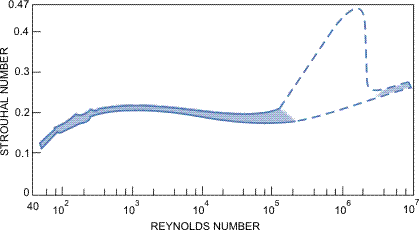

Source: http://thermopedia.com/content/1247/

### Finding all Strouhal numbers

After fiddling a bit with the `window_size` below,
it seems 400 yields fairly stable estimates of the Strouhal number.


In [29]:
strouhal_data = val.load_strouhal(dataset, window_size=400)
pd.DataFrame(strouhal_data, columns=('Reynolds', 'Strouhal'))

,Reynolds,Strouhal
0,10,100.000000
1,25,40.000000
2,50,20.000000
3,75,0.133333
4,100,0.100000
5,125,0.120000
6,150,0.133333
7,175,0.114286
8,200,0.125000
9,225,0.133333


In [35]:
pd.DataFrame(strouhal_data[5:], columns=('Reynolds', 'Strouhal'))

,Reynolds,Strouhal
0,125,0.120000
1,150,0.133333
2,175,0.114286
3,200,0.125000
4,225,0.133333
5,250,0.140000
6,275,0.127273
7,300,0.133333


I contend these numbers (about 0.13 from Reynolds = 125 up to 300)
are fairly accurate in light of the image linked above.

Finally, we plot the Strouhal numbers.
First, we define the filename to save the plot to.

In [30]:
strouhal_plot_file = 'strouhal.png'

And how many of the cases to throw away:

In [31]:
throw_away = 3

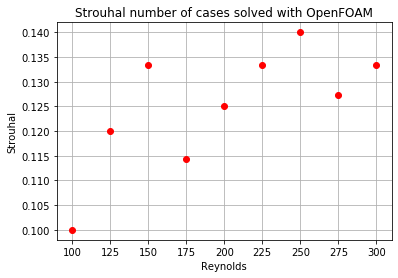

In [32]:
strouhal_numpy = np.array(strouhal_data)

rey_series = strouhal_numpy[throw_away + 1:, 0]
str_series = strouhal_numpy[throw_away + 1:, 1]

plt.plot(rey_series,
         str_series,
         'ro')
plt.xlabel('Reynolds')
plt.ylabel('Strouhal')
plt.title('Strouhal number of cases solved with OpenFOAM')
plt.grid()
plt.savefig(strouhal_plot_file)
plt.show()